# Convert a PyTorch Model to ONNX and OpenVINO™ IR

This tutorial demonstrates step-by-step instructions on how to do inference on a PyTorch semantic segmentation model, using OpenVINO Runtime.

First, the PyTorch model is exported in [ONNX](https://onnx.ai/) format and then converted to OpenVINO IR. Then the respective ONNX and OpenVINO IR models are loaded into OpenVINO Runtime to show model predictions.
In this tutorial, we will use LR-ASPP model with MobileNetV3 backbone.

According to the paper, [Searching for MobileNetV3](https://arxiv.org/pdf/1905.02244.pdf), LR-ASPP or Lite Reduced Atrous Spatial Pyramid Pooling has a lightweight and efficient segmentation decoder architecture. The diagram below illustrates the model architecture:

![image](https://user-images.githubusercontent.com/29454499/207099169-48dca3dc-a8eb-4e11-be92-40cebeec7a88.png)

The model is pre-trained on the [MS COCO](https://cocodataset.org/#home) dataset. Instead of training on all 80 classes, the segmentation model has been trained on 20 classes from the [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset:
***background*, *aeroplane*, *bicycle*, *bird*, *boat*, *bottle*, *bus*, *car*, *cat*, *chair*, *cow*, *dining table*, *dog*, *horse*, *motorbike*, *person*, *potted plant*, *sheep*, *sofa*, *train*, *tv monitor***

More information about the model is available in the [torchvision documentation](https://pytorch.org/vision/main/models/lraspp.html)


#### Table of contents:

- [Preparation](#Preparation)
    - [Imports](#Imports)
    - [Settings](#Settings)
    - [Load Model](#Load-Model)
- [ONNX Model Conversion](#ONNX-Model-Conversion)
    - [Convert PyTorch model to ONNX](#Convert-PyTorch-model-to-ONNX)
    - [Convert ONNX Model to OpenVINO IR Format](#Convert-ONNX-Model-to-OpenVINO-IR-Format)
- [Show Results](#Show-Results)
    - [Load and Preprocess an Input Image](#Load-and-Preprocess-an-Input-Image)
    - [Load the OpenVINO IR Network and Run Inference on the ONNX model](#Load-the-OpenVINO-IR-Network-and-Run-Inference-on-the-ONNX-model)
        - [1. ONNX Model in OpenVINO Runtime](#1.-ONNX-Model-in-OpenVINO-Runtime)
        - [Select inference device](#Select-inference-device)
        - [2. OpenVINO IR Model in OpenVINO Runtime](#2.-OpenVINO-IR-Model-in-OpenVINO-Runtime)
        - [Select inference device](#Select-inference-device)
- [PyTorch Comparison](#PyTorch-Comparison)
- [Performance Comparison](#Performance-Comparison)
- [References](#References)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/pytorch-to-openvino/pytorch-onnx-to-openvino.ipynb" />


In [1]:
# Install openvino package
%pip install -q "openvino>=2023.1.0" onnx torch torchvision opencv-python tqdm --extra-index-url https://download.pytorch.org/whl/cpu

## Preparation
[back to top ⬆️](#Table-of-contents:)

### Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import time
import warnings
from pathlib import Path

import cv2
import numpy as np
import openvino as ov
import torch
from torchvision.models.segmentation import (
    lraspp_mobilenet_v3_large,
    LRASPP_MobileNet_V3_Large_Weights,
)

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import segmentation_map_to_image, viz_result_image, SegmentationMap, Label, download_file, device_widget

### Settings
[back to top ⬆️](#Table-of-contents:)

Set a name for the model, then define width and height of the image that will be used by the network during inference. According to the input transforms function, the model is pre-trained on images with a height of 520 and width of 780.

In [3]:
IMAGE_WIDTH = 780
IMAGE_HEIGHT = 520
DIRECTORY_NAME = "model"
BASE_MODEL_NAME = DIRECTORY_NAME + "/lraspp_mobilenet_v3_large"
weights_path = Path(BASE_MODEL_NAME + ".pt")

# Paths where ONNX and OpenVINO IR models will be stored.
onnx_path = weights_path.with_suffix(".onnx")
if not onnx_path.parent.exists():
    onnx_path.parent.mkdir()
ir_path = onnx_path.with_suffix(".xml")

### Load Model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of `torch.nn.Module` class, initialized by a state dictionary with model weights.
Typical steps for getting a pre-trained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pre-trained model weights
3. Turn model to evaluation for switching some operations to inference mode

The `torchvision` module provides a ready to use set of functions for model class initialization. We will use `torchvision.models.segmentation.lraspp_mobilenet_v3_large`. You can directly pass pre-trained model weights to the model initialization function using weights enum `LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. However, for demonstration purposes, we will create it separately. Download the pre-trained weights and load the model. This may take some time if you have not downloaded the model before.

In [4]:
print("Downloading the LRASPP MobileNetV3 model (if it has not been downloaded already)...")
download_file(
    LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.url,
    filename=weights_path.name,
    directory=weights_path.parent,
)
# create model object
model = lraspp_mobilenet_v3_large()
# read state dict, use map_location argument to avoid a situation where weights are saved in cuda (which may not be unavailable on the system)
state_dict = torch.load(weights_path, map_location="cpu")
# load state dict to model
model.load_state_dict(state_dict)
# switch model from training to inference mode
model.eval()
print("Loaded PyTorch LRASPP MobileNetV3 model")

'model/lraspp_mobilenet_v3_large.pt' already exists.
Loaded PyTorch LRASPP MobileNetV3 model


## ONNX Model Conversion
[back to top ⬆️](#Table-of-contents:)

### Convert PyTorch model to ONNX
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models that are exported in ONNX format. We will use the `torch.onnx.export` function to obtain the ONNX model, you can learn more about this feature in the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). We need to provide a model object, example input for model tracing and path where the model will be saved. When providing example input, it is not necessary to use real data, dummy input data with specified shape is sufficient. Optionally, we can provide a target onnx opset for conversion and/or other parameters specified in documentation (e.g. input and output names or dynamic shapes).

Sometimes a warning will be shown, but in most cases it is harmless, so let us just filter it out. When the conversion is successful, the last line of the output will read: `ONNX model exported to model/lraspp_mobilenet_v3_large.onnx.`

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not onnx_path.exists():
        dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
        )
        print(f"ONNX model exported to {onnx_path}.")
    else:
        print(f"ONNX model {onnx_path} already exists.")

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX model exported to model/lraspp_mobilenet_v3_large.onnx.


### Convert ONNX Model to OpenVINO IR Format
[back to top ⬆️](#Table-of-contents:)

To convert the ONNX model to OpenVINO IR with `FP16` precision, use model conversion API. The models are saved inside the current directory. For more information on how to convert models, see this [page](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html).

In [6]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    ov_model = ov.convert_model(onnx_path)
    ov.save_model(ov_model, ir_path)
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.


## Show Results
[back to top ⬆️](#Table-of-contents:)

Confirm that the segmentation results look as expected by comparing model predictions on the ONNX, OpenVINO IR and PyTorch models.

### Load and Preprocess an Input Image
[back to top ⬆️](#Table-of-contents:)

Images need to be normalized before propagating through the network.

In [7]:
def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to the given mean and standard deviation
    for CityScapes models.
    """
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

In [8]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

image = cv2.cvtColor(cv2.imread(str(image_filename)), cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
normalized_image = normalize(resized_image)

# Convert the resized images to network input shape.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0)

### Load the OpenVINO IR Network and Run Inference on the ONNX model
[back to top ⬆️](#Table-of-contents:)

OpenVINO Runtime can load ONNX models directly. First, load the ONNX model, do inference and show the results. Then, load the model that was converted to OpenVINO Intermediate Representation (OpenVINO IR) with OpenVINO Converter and do inference on that model, and show the results on an image.

#### 1. ONNX Model in OpenVINO Runtime
[back to top ⬆️](#Table-of-contents:)


In [9]:
# Instantiate OpenVINO Core
core = ov.Core()

# Read model to OpenVINO Runtime
model_onnx = core.read_model(model=onnx_path)

#### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [10]:
device = device_widget()

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [11]:
# Load model on device
compiled_model_onnx = core.compile_model(model=model_onnx, device_name=device.value)

# Run inference on the input image
res_onnx = compiled_model_onnx([normalized_input_image])[0]

Model predicts probabilities for how well each pixel corresponds to a specific label. To get the label with highest probability for each pixel, operation argmax should be applied. After that, color coding can be applied to each label for more convenient visualization.

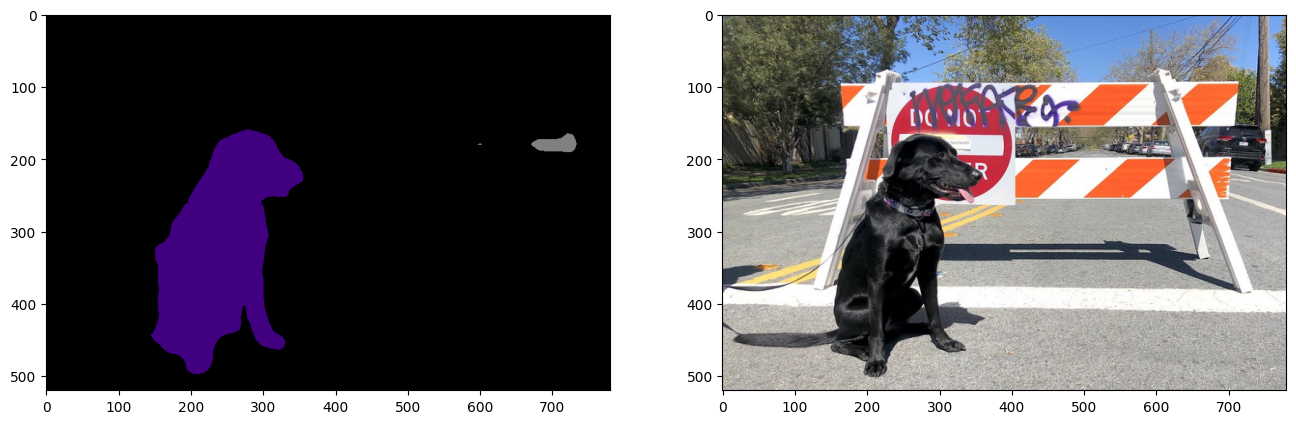

In [12]:
voc_labels = [
    Label(index=0, color=(0, 0, 0), name="background"),
    Label(index=1, color=(128, 0, 0), name="aeroplane"),
    Label(index=2, color=(0, 128, 0), name="bicycle"),
    Label(index=3, color=(128, 128, 0), name="bird"),
    Label(index=4, color=(0, 0, 128), name="boat"),
    Label(index=5, color=(128, 0, 128), name="bottle"),
    Label(index=6, color=(0, 128, 128), name="bus"),
    Label(index=7, color=(128, 128, 128), name="car"),
    Label(index=8, color=(64, 0, 0), name="cat"),
    Label(index=9, color=(192, 0, 0), name="chair"),
    Label(index=10, color=(64, 128, 0), name="cow"),
    Label(index=11, color=(192, 128, 0), name="dining table"),
    Label(index=12, color=(64, 0, 128), name="dog"),
    Label(index=13, color=(192, 0, 128), name="horse"),
    Label(index=14, color=(64, 128, 128), name="motorbike"),
    Label(index=15, color=(192, 128, 128), name="person"),
    Label(index=16, color=(0, 64, 0), name="potted plant"),
    Label(index=17, color=(128, 64, 0), name="sheep"),
    Label(index=18, color=(0, 192, 0), name="sofa"),
    Label(index=19, color=(128, 192, 0), name="train"),
    Label(index=20, color=(0, 64, 128), name="tv monitor"),
]
VOCLabels = SegmentationMap(voc_labels)

# Convert the network result to a segmentation map and display the result.
result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result_mask_onnx, VOCLabels.get_colormap()),
    resize=True,
)

#### 2. OpenVINO IR Model in OpenVINO Runtime
[back to top ⬆️](#Table-of-contents:)


#### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [13]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [14]:
# Load the network in OpenVINO Runtime.
core = ov.Core()
model_ir = core.read_model(model=ir_path)
compiled_model_ir = core.compile_model(model=model_ir, device_name=device.value)

# Get input and output layers.
output_layer_ir = compiled_model_ir.output(0)

# Run inference on the input image.
res_ir = compiled_model_ir([normalized_input_image])[output_layer_ir]

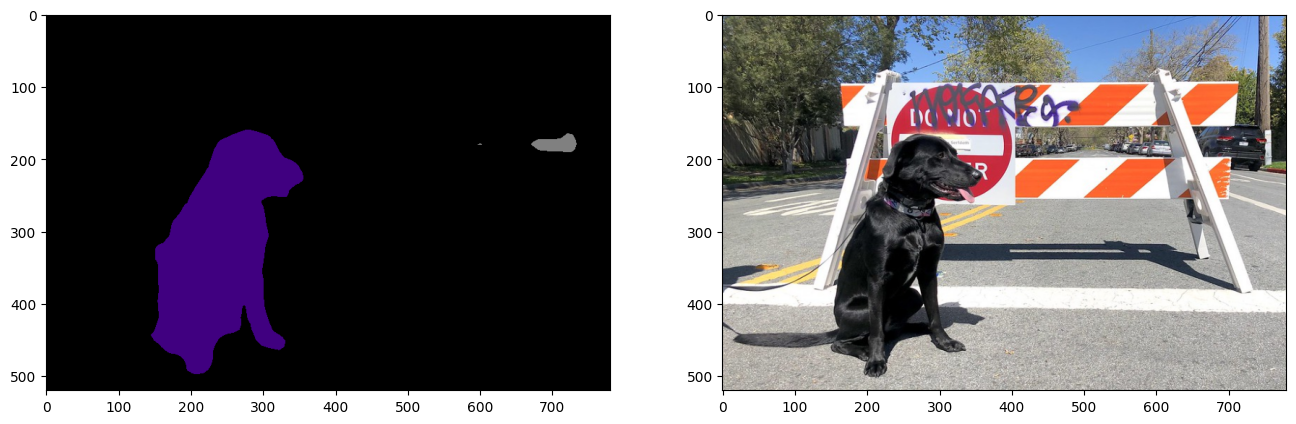

In [15]:
result_mask_ir = np.squeeze(np.argmax(res_ir, axis=1)).astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result=result_mask_ir, colormap=VOCLabels.get_colormap()),
    resize=True,
)

## PyTorch Comparison
[back to top ⬆️](#Table-of-contents:)

Do inference on the PyTorch model to verify that the output visually looks the same as the output on the ONNX/OpenVINO IR models.

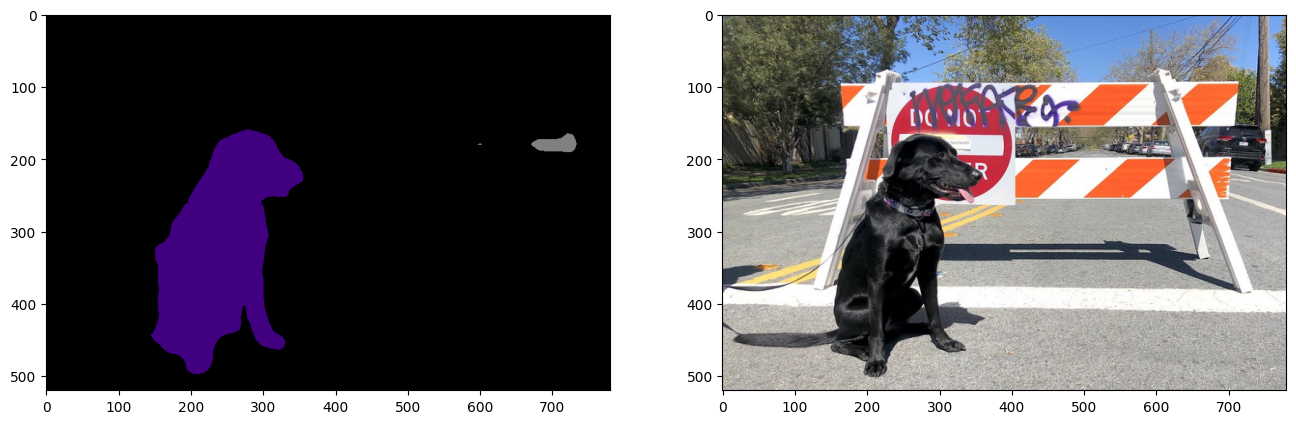

In [16]:
model.eval()
with torch.no_grad():
    result_torch = model(torch.as_tensor(normalized_input_image).float())

result_mask_torch = torch.argmax(result_torch["out"], dim=1).squeeze(0).numpy().astype(np.uint8)
viz_result_image(
    image,
    segmentation_map_to_image(result=result_mask_torch, colormap=VOCLabels.get_colormap()),
    resize=True,
)

## Performance Comparison
[back to top ⬆️](#Table-of-contents:)

Measure the time it takes to do inference on twenty images. This gives an indication of performance. For more accurate benchmarking, use the [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html). Keep in mind that many optimizations are possible to improve the performance. 

In [17]:
num_images = 100

with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        model(torch.as_tensor(input_image).float())
    end = time.perf_counter()
    time_torch = end - start
print(f"PyTorch model on CPU: {time_torch/num_images:.3f} seconds per image, " f"FPS: {num_images/time_torch:.2f}")

compiled_model_onnx = core.compile_model(model=model_onnx, device_name=device.value)
start = time.perf_counter()
for _ in range(num_images):
    compiled_model_onnx([normalized_input_image])
end = time.perf_counter()
time_onnx = end - start
print(f"ONNX model in OpenVINO Runtime/{device.value}: {time_onnx/num_images:.3f} " f"seconds per image, FPS: {num_images/time_onnx:.2f}")

compiled_model_ir = core.compile_model(model=model_ir, device_name=device.value)
start = time.perf_counter()
for _ in range(num_images):
    compiled_model_ir([input_image])
end = time.perf_counter()
time_ir = end - start
print(f"OpenVINO IR model in OpenVINO Runtime/{device.value}: {time_ir/num_images:.3f} " f"seconds per image, FPS: {num_images/time_ir:.2f}")

PyTorch model on CPU: 0.038 seconds per image, FPS: 26.50
ONNX model in OpenVINO Runtime/CPU: 0.026 seconds per image, FPS: 38.21
OpenVINO IR model in OpenVINO Runtime/CPU: 0.026 seconds per image, FPS: 38.87


75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.


ONNX model in OpenVINO/GPU: 0.035 seconds per image, FPS: 28.38


75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.
75 warnings generated.


IR model in OpenVINO/GPU: 0.035 seconds per image, FPS: 28.22


**Show Device Information**

In [18]:
import openvino.properties as props


devices = core.available_devices
for device in devices:
    device_name = core.get_property(device, props.device.full_name)
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz
GPU: NVIDIA GeForce RTX 3090 (dGPU)


## References
[back to top ⬆️](#Table-of-contents:)

* [Torchvision](https://pytorch.org/vision/stable/index.html)
* [Pytorch ONNX Documentation](https://pytorch.org/docs/stable/onnx.html)
* [PIP install openvino](https://pypi.org/project/openvino/)
* [OpenVINO ONNX support](https://docs.openvino.ai/2021.4/openvino_docs_IE_DG_ONNX_Support.html)
* [Model Conversion API documentation](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html)
* [Converting Pytorch model](https://docs.openvino.ai/2024/openvino-workflow/model-preparation/convert-model-pytorch.html)
